# Information

**Author:**<br>Pascal Munaretto (<a href="mailto:pascal.munaretto@outlook.com">Mail</a>)

**Date:**<br>30.09.2022

**Type:**<br>Master's Thesis

**Topic:**<br>Design, Implementation and Performance Analysis of an AI-Based Insider Threat Detection Platform	in Splunk To Counteract Data Exfiltration

**Study Program:**<br>Enterprise and IT Security

**Institution:**<br><a href="https://www.hs-offenburg.de">Offenburg University of Applied Sciences</a>

**Github:**<br>https://github.com/pmunaretto/Master-Thesis

## Requirements

In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
!pip install pyod datetimerange

## Imports

In [ ]:
import os
import math
import sys
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import torch
import tensorflow as tf
import functools as ft
import json
import glob
from pickle import PicklingError
from joblib import dump, load
from timeit import default_timer as timer
from random import seed, randint
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, recall_score, classification_report, f1_score, accuracy_score, precision_score, confusion_matrix, matthews_corrcoef, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from datetime import datetime, timedelta
from tensorflow import keras
from matplotlib.backends.backend_pgf import FigureCanvasPgf
from matplotlib.ticker import PercentFormatter
from matplotlib import colors
from datetimerange import DateTimeRange
from pyod.models.iforest import IForest
from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD
from pyod.models.loda import LODA
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.pca import PCA
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from pyod.models.deep_svdd import DeepSVDD
from pyod.utils.data import evaluate_print
from IPython.display import display, Markdown

## Configuration

In [ ]:
matplotlib.backend_bases.register_backend("pgf", FigureCanvasPgf)

plt.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "font.size": 16,
    "image.cmap": "plasma",
    "axes.prop_cycle": plt.cycler("color", ["b", "g", "c", "m", "y", "r"]), 
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False
})

tf.get_logger().setLevel("WARN")

# Global Configuration
BASE_PATH    = "/content/drive/MyDrive/CERT/r4.2"
TIME_WINDOWS = pd.read_csv(os.path.join(BASE_PATH, "time_window_detailed_insiders.csv"), index_col=0)
LOOKBACK     = [5, 10, 15, 20]

## Helper Functions

In [ ]:
def add_insider_label(row):
    user = row.name[1]
    insiders = ["AAM0658","AJR0932","BDV0168","BIH0745","BLS0678","BTL0226","CAH0936","DCH0843","EHB0824","EHD0584","FMG0527","FTM0406","GHL0460","HJB0742","JMB0308","JRG0207","KLH0596","KPC0073","LJR0523","LQC0479","MAR0955","MAS0025","MCF0600","MYD0978","PPF0435","RAB0589","RGG0064","RKD0604","TAP0551","WDD0366","AAF0535","ABC0174","AKR0057","CCL0068","CEJ0109","CQW0652","DIB0285","DRR0162","EDB0714","EGD0132","FSC0601","HBO0413","HXL0968","IJM0776","IKR0401","IUB0565","JJM0203","KRL0501","LCC0819","MDH0580","MOS0047","NWT0098","PNL0301","PSF0133","RAR0725","RHL0992","RMW0542","TNM0961","VSS0154","XHW0498"]
    if user in insiders:
        row["insider"] = 1
        return row
    else:
        row["insider"] = 0
        return row

def add_label(row):
    date = row.name[0]
    user = row.name[1]
    if user in TIME_WINDOWS.index:
        ts1 = datetime.strptime(TIME_WINDOWS.loc[user].first_insider_activity, "%m/%d/%Y:%H:%M:%S")
        ts2 = datetime.strptime(TIME_WINDOWS.loc[user].last_insider_activity, "%m/%d/%Y:%H:%M:%S")
        time_range1 = DateTimeRange(ts1, ts2)
        time_range2 = DateTimeRange(date-timedelta(days=30), date+timedelta(days=1))
        if time_range1.is_intersection(time_range2):
            row["insider_in_30_day_window"] = 1
            return row
    row["insider_in_30_day_window"] = 0
    return row

def print_debug_message(entry):
    print(f"\033[1;31m{datetime.now().strftime('%H:%M:%S')} - {entry.iteration}: Days: {entry.days} Params: {entry.params}\033[0m")
    print(f"Top 1:  (1) {entry.scenario1_top1:>2} |  (2) {entry.scenario2_top1:>2} |  (All) {entry.all_top1:>2}")
    print(f"Top 3:  (1) {entry.scenario1_top3:>2} |  (2) {entry.scenario2_top3:>2} |  (All) {entry.all_top3:>2}")
    print(f"Top 5:  (1) {entry.scenario1_top5:>2} |  (2) {entry.scenario2_top5:>2} |  (All) {entry.all_top5:>2}")
    print(f"Top 10: (1) {entry.scenario1_top10:>2} |  (2) {entry.scenario2_top10:>2} |  (All) {entry.all_top10:>2}")
    print(f"Top 20: (1) {entry.scenario1_top20:>2} |  (2) {entry.scenario2_top20:>2} |  (All) {entry.all_top20:>2}")
    print(f"Top 30: (1) {entry.scenario1_top30:>2} |  (2) {entry.scenario2_top30:>2} |  (All) {entry.all_top30:>2}")
    print(f"Top 50: (1) {entry.scenario1_top50:>2} |  (2) {entry.scenario2_top50:>2} |  (All) {entry.all_top50:>2}")

# Risk Score Intermediate Results

In [ ]:
# Define the transformers that do the rest of the preprocessing (scaling, encoding)
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])
categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder())
])

# Read datasets
logon  = pd.read_parquet(os.path.join(BASE_PATH, "preprocessed", "logon"), columns=["date", "user", "hour_sin", "hour_cos", "activity"])
device = pd.read_parquet(os.path.join(BASE_PATH, "preprocessed", "device"), columns=["date", "user", "activity"])
http   = pd.read_parquet(os.path.join(BASE_PATH, "preprocessed", "http"), columns=["date", "user", "is_job_portal", "url"])

# Preprocessing the device events for the second use case
device_buckets = device.groupby([device["user"], pd.Grouper(freq="1d", key="date")]).size().to_frame("count")
device_buckets = device_buckets.reindex(pd.MultiIndex.from_product(device_buckets.index.levels))
device_buckets = device_buckets.fillna(0).reset_index()

# Initialize the dataframes that store the intermediate results
results_uc1 = pd.DataFrame()
results_uc2 = pd.DataFrame()
results_uc3 = pd.DataFrame()
results_uc4 = pd.DataFrame()
results_uc5 = pd.DataFrame()

# Loop over all dates (starting from June since this is where the first attack occurs)
for date in pd.date_range(start="06/01/10", end="05/17/11"):

    print(f"Processing {date}")

    # Initialize the timestamps for filtering the dataframes
    ts1_start = date
    ts2_end   = date + pd.DateOffset(1)
    ts3_30d   = date + pd.DateOffset(-30)

    # Use Case 1: Anomalous Logon Behavior
    accumulated_logon_events  = logon[(logon["date"] < ts1_start)]
    current_date_logon_events = logon[(logon["date"] >= ts1_start) & (logon["date"] < ts2_end)]
    grouped = accumulated_logon_events.groupby("user")
    for user, training_df in grouped:
        inference_df = current_date_logon_events[current_date_logon_events["user"] == user][["activity", "hour_sin", "hour_cos"]]
        if not inference_df.empty:
            pipe = Pipeline([
                ("column_transformer", ColumnTransformer(
                    transformers=[
                        ("num", numeric_transformer, selector(dtype_exclude=["category", "object"])),
                        ("cat", categorical_transformer, selector(dtype_include=["category", "object"]))
                    ]
                )),
                ("classifier", ECOD())
            ])
            pipe.fit(training_df[["activity", "hour_sin", "hour_cos"]])
            scores = pipe.decision_function(inference_df)
            entry = pd.Series(
                {
                    "date": date,
                    "user": user,
                    "sum_of_logon_anomaly_scores": scores.sum(),
                    "max_of_logon_anomaly_scores": scores.max(),
                    "avg_of_logon_anomaly_scores": scores.mean(),
                    "25q_of_logon_anomaly_scores": np.quantile(scores, q=0.25),
                    "50q_of_logon_anomaly_scores": np.quantile(scores, q=0.5),
                    "75q_of_logon_anomaly_scores": np.quantile(scores, q=0.75)
                }
            )
            results_uc1 = results_uc1.append(entry, ignore_index=True)
        else:
            continue
    
    # Use Case 2: Anomlaous Device Usage
    accumulated_device_events  = device_buckets[(device_buckets["date"] < ts1_start)]
    current_date_device_events = device_buckets[(device_buckets["date"] >= ts1_start) & (device_buckets["date"] < ts2_end)]
    grouped = accumulated_device_events.groupby("user")
    for user, training_df in grouped:
        inference_df = current_date_device_events[current_date_device_events["user"] == user][["count"]]
        if not inference_df.empty:
            pipe = Pipeline([
                ("column_transformer", ColumnTransformer(
                    transformers=[
                        ("num", numeric_transformer, selector(dtype_exclude=["category", "object"])),
                        ("cat", categorical_transformer, selector(dtype_include=["category", "object"]))
                    ]
                )),
                ("classifier", COPOD())
            ])
            pipe.fit(training_df[["count"]])
            scores = pipe.decision_function(inference_df)
            entry = pd.Series(
                {
                    "date": date,
                    "user": user,
                    "sum_of_device_anomaly_scores": scores.sum(),
                    "max_of_device_anomaly_scores": scores.max(),
                    "avg_of_device_anomaly_scores": scores.mean(),
                    "25q_of_device_anomaly_scores": np.quantile(scores, q=0.25),
                    "50q_of_device_anomaly_scores": np.quantile(scores, q=0.5),
                    "75q_of_device_anomaly_scores": np.quantile(scores, q=0.75)
                }
            )
            results_uc2 = results_uc2.append(entry, ignore_index=True)
        else:
            continue
    
    # Use Case 3: Browsing Job Sites
    current_day = http[(http["date"] >= ts1_start) & (http["date"] < ts2_end) & (http["is_job_portal"] == 1)]
    if not current_day.empty:
        tmp = current_day.groupby("user").size().to_frame("sum_of_job_portals_visited").reset_index()
        tmp["date"] = date
        results_uc3 = pd.concat([results_uc3, tmp], ignore_index=True)

    # Use Case 4: First Time USB Usage
    past_30_days = device_buckets[(device_buckets["date"] >= ts3_30d) & (device_buckets["date"] < ts1_start)].reset_index()
    current_day  = device_buckets[(device_buckets["date"] >= ts1_start) & (device_buckets["date"] < ts2_end)].reset_index()
    if not current_day.empty:
        tmp = current_day.groupby("user").apply(lambda x: 0 if past_30_days.user.str.contains(x.name).any() else 1).to_frame("first_time_usb_usage_in_past_30_days").reset_index()
        tmp["date"] = date
        results_uc4 = pd.concat([results_uc4, tmp], ignore_index=True)

    # Use Case 5: Upload to Wikileaks
    current_day = http[(http["date"] >= ts1_start) & (http["date"] < ts2_end) & (http["url"] == "wikileaks.org")]
    if not current_day.empty:
        tmp = current_day.groupby("user").size().to_frame("sum_of_wikileaks_uploads").reset_index()
        tmp["date"] = date
        results_uc5 = pd.concat([results_uc5, tmp], ignore_index=True)

# Merge the results to a single dataframe by performing an outer join on the date and user column
intermediate_results = ft.reduce(
    lambda left, right: pd.merge(left, right, on=["date", "user"], how="outer"),
    [results_uc1, results_uc2, results_uc3, results_uc4, results_uc5]
)

# Set the date and user to the multi-index
intermediate_results = intermediate_results.set_index(["date", "user"])

# Fill missing values
intermediate_results = intermediate_results.fillna(0)

# Store the results to a file
intermediate_results.to_csv(os.path.join(BASE_PATH, "risk_scores", "risk_scores_intermediate_results2.csv"))
intermediate_results

In [ ]:
intermediate_results = pd.read_csv(os.path.join(BASE_PATH, "risk_scores", "intermediate_results.csv"), index_col=[0, 1], parse_dates=True)
intermediate_results

sum_of_logon_anomaly_scores  max_of_logon_anomaly_scores  \
date       user                                                                
2010-06-01 AAE0190                     4.158883                     2.079442   
           AAF0535                     4.842552                     2.763110   
           AAF0791                     4.158883                     2.079442   
           AAL0706                     4.158883                     2.079442   
           AAM0658                     4.158883                     2.079442   
...                                         ...                          ...   
2011-05-16 VSA0230                     0.000000                     0.000000   
           VSS0154                     0.000000                     0.000000   
           WDD0366                     0.000000                     0.000000   
           XHW0498                     0.000000                     0.000000   
           XWD0923                     0.000000                     0.000000   

                    avg_of_logon_anomaly_scores  25q_of_logon_anomaly_scores  \
date       user                                                                
2010-06-01 AAE0190                     2.079442                     2.079442   
           AAF0535                     2.421276                     2.250359   
           AAF0791                     2.079442                     2.079442   
           AAL0706                     2.079442                     2.079442   
           AAM0658                     2.079442                     2.079442   
...                                         ...                          ...   
2011-05-16 VSA0230                     0.000000                     0.000000   
           VSS0154                     0.000000                     0.000000   
           WDD0366                     0.000000                     0.000000   
           XHW0498                     0.000000                     0.000000   
           XWD0923                     0.000000                     0.000000   

                    50q_of_logon_anomaly_scores  75q_of_logon_anomaly_scores  \
date       user                                                                
2010-06-01 AAE0190                     2.079442                     2.079442   
           AAF0535                     2.421276                     2.592193   
           AAF0791                     2.079442                     2.079442   
           AAL0706                     2.079442                     2.079442   
           AAM0658                     2.079442                     2.079442   
...                                         ...                          ...   
2011-05-16 VSA0230                     0.000000                     0.000000   
           VSS0154                     0.000000                     0.000000   
           WDD0366                     0.000000                     0.000000   
           XHW0498                     0.000000                     0.000000   
           XWD0923                     0.000000                     0.000000   

                    sum_of_device_anomaly_scores  \
date       user                                    
2010-06-01 AAE0190                      0.000000   
           AAF0535                      0.726820   
           AAF0791                      0.000000   
           AAL0706                      0.000000   
           AAM0658                      0.000000   
...                                          ...   
2011-05-16 VSA0230                      0.091961   
           VSS0154                      0.255413   
           WDD0366                      0.004016   
           XHW0498                      0.229433   
           XWD0923                      0.319329   

                    max_of_device_anomaly_scores  \
date       user                                    
2010-06-01 AAE0190                      0.000000   
           AAF0535                      0.726820   
           A

# Risk Score Aggregations

In [ ]:
def apply_lookback_aggregations(group):
    entry = pd.Series(dtype="float64")
    entry["sum_of_sum_of_logon_anomaly_scores"]          = group["sum_of_logon_anomaly_scores"].sum()
    entry["avg_of_sum_of_logon_anomaly_scores"]          = group["sum_of_logon_anomaly_scores"].mean()
    entry["max_of_sum_of_logon_anomaly_scores"]          = group["sum_of_logon_anomaly_scores"].max()
    entry["sum_of_avg_of_logon_anomaly_scores"]          = group["avg_of_logon_anomaly_scores"].sum()
    entry["avg_of_avg_of_logon_anomaly_scores"]          = group["avg_of_logon_anomaly_scores"].mean()
    entry["max_of_avg_of_logon_anomaly_scores"]          = group["avg_of_logon_anomaly_scores"].max()
    entry["sum_of_max_of_logon_anomaly_scores"]          = group["max_of_logon_anomaly_scores"].sum()
    entry["avg_of_max_of_logon_anomaly_scores"]          = group["max_of_logon_anomaly_scores"].mean()
    entry["max_of_max_of_logon_anomaly_scores"]          = group["max_of_logon_anomaly_scores"].max()
    entry["sum_of_25q_of_logon_anomaly_scores"]          = group["25q_of_logon_anomaly_scores"].sum()
    entry["avg_of_25q_of_logon_anomaly_scores"]          = group["25q_of_logon_anomaly_scores"].mean()
    entry["max_of_25q_of_logon_anomaly_scores"]          = group["25q_of_logon_anomaly_scores"].max()
    entry["sum_of_50q_of_logon_anomaly_scores"]          = group["50q_of_logon_anomaly_scores"].sum()
    entry["avg_of_50q_of_logon_anomaly_scores"]          = group["50q_of_logon_anomaly_scores"].mean()
    entry["max_of_50q_of_logon_anomaly_scores"]          = group["50q_of_logon_anomaly_scores"].max()
    entry["sum_of_75q_of_logon_anomaly_scores"]          = group["75q_of_logon_anomaly_scores"].sum()
    entry["avg_of_75q_of_logon_anomaly_scores"]          = group["75q_of_logon_anomaly_scores"].mean()
    entry["max_of_75q_of_logon_anomaly_scores"]          = group["75q_of_logon_anomaly_scores"].max()
    entry["sum_of_sum_of_device_anomaly_scores"]         = group["sum_of_device_anomaly_scores"].sum()
    entry["avg_of_sum_of_device_anomaly_scores"]         = group["sum_of_device_anomaly_scores"].mean()
    entry["max_of_sum_of_device_anomaly_scores"]         = group["sum_of_device_anomaly_scores"].max()
    entry["sum_of_avg_of_device_anomaly_scores"]         = group["avg_of_device_anomaly_scores"].sum()
    entry["avg_of_avg_of_device_anomaly_scores"]         = group["avg_of_device_anomaly_scores"].mean()
    entry["max_of_avg_of_device_anomaly_scores"]         = group["avg_of_device_anomaly_scores"].max()
    entry["sum_of_max_of_device_anomaly_scores"]         = group["max_of_device_anomaly_scores"].sum()
    entry["avg_of_max_of_device_anomaly_scores"]         = group["max_of_device_anomaly_scores"].mean()
    entry["max_of_max_of_device_anomaly_scores"]         = group["max_of_device_anomaly_scores"].max()
    entry["sum_of_25q_of_device_anomaly_scores"]         = group["25q_of_device_anomaly_scores"].sum()
    entry["avg_of_25q_of_device_anomaly_scores"]         = group["25q_of_device_anomaly_scores"].mean()
    entry["max_of_25q_of_device_anomaly_scores"]         = group["25q_of_device_anomaly_scores"].max()
    entry["sum_of_50q_of_device_anomaly_scores"]         = group["50q_of_device_anomaly_scores"].sum()
    entry["avg_of_50q_of_device_anomaly_scores"]         = group["50q_of_device_anomaly_scores"].mean()
    entry["max_of_50q_of_device_anomaly_scores"]         = group["50q_of_device_anomaly_scores"].max()
    entry["sum_of_75q_of_device_anomaly_scores"]         = group["75q_of_device_anomaly_scores"].sum()
    entry["avg_of_75q_of_device_anomaly_scores"]         = group["75q_of_device_anomaly_scores"].mean()
    entry["max_of_75q_of_device_anomaly_scores"]         = group["75q_of_device_anomaly_scores"].max()
    entry["sum_of_job_portals_visited"]                  = group["sum_of_job_portals_visited"].sum()
    entry["avg_of_job_portals_visited"]                  = group["sum_of_job_portals_visited"].mean()
    entry["max_of_job_portals_visited"]                  = group["sum_of_job_portals_visited"].max()
    entry["any_of_job_portals_visited"]                  = group["sum_of_job_portals_visited"].any()
    entry["any_of_first_time_usb_usage_in_past_30_days"] = group["first_time_usb_usage_in_past_30_days"].any()
    entry["sum_of_wikileaks_uploads"]                    = group["sum_of_wikileaks_uploads"].sum()
    entry["avg_of_wikileaks_uploads"]                    = group["sum_of_wikileaks_uploads"].mean()
    entry["max_of_wikileaks_uploads"]                    = group["sum_of_wikileaks_uploads"].max()
    entry["any_of_wikileaks_uploads"]                    = group["sum_of_wikileaks_uploads"].any()
    return entry

for days in [14, 21, 28, 42, 49, 56, 63, 70]:

    print(f"Lookback: {days}")

    risk_score_aggregations = pd.DataFrame()
    for date in pd.date_range(start="01/02/10", end="05/17/11"):

            print(f"{date}: {datetime.now().strftime('%H:%M:%S')}")

            # Initialize the timestamps for filtering the dataframe
            ts1 = date + pd.DateOffset(-days)
            ts2 = date + pd.DateOffset(1)

            # Filter the past 30 days of the intermediate results (including the current day)
            df = intermediate_results[
                    (intermediate_results.index.get_level_values(0) >= ts1) & 
                    (intermediate_results.index.get_level_values(0) < ts2)
            ]

            # Group by users, normalize, add the date column and calculate risk score by averaging all indicators
            grouped = df.groupby("user").apply(apply_lookback_aggregations)
            grouped = (grouped - grouped.min()) / (grouped.max() - grouped.min())
            grouped = grouped.reset_index()
            grouped["date"] = date
            risk_score_aggregations = risk_score_aggregations.append(grouped)

    # Store the results to a file
    risk_score_aggregations = risk_score_aggregations.set_index(["date", "user"])
    risk_score_aggregations.to_parquet(os.path.join(BASE_PATH, "risk_scores", "aggregations", f"{days}_days.parquet"))

Lookback: 14
2010-01-02 00:00:00: 18:53:32
2010-01-03 00:00:00: 18:53:32
2010-01-04 00:00:00: 18:53:32
2010-01-05 00:00:00: 18:53:32
2010-01-06 00:00:00: 18:53:32
2010-01-07 00:00:00: 18:53:32
2010-01-08 00:00:00: 18:53:32
2010-01-09 00:00:00: 18:53:32
2010-01-10 00:00:00: 18:53:32
2010-01-11 00:00:00: 18:53:32
2010-01-12 00:00:00: 18:53:32
2010-01-13 00:00:00: 18:53:32
2010-01-14 00:00:00: 18:53:32
2010-01-15 00:00:00: 18:53:32
2010-01-16 00:00:00: 18:53:32
2010-01-17 00:00:00: 18:53:32
2010-01-18 00:00:00: 18:53:32
2010-01-19 00:00:00: 18:53:32
2010-01-20 00:00:00: 18:53:32
2010-01-21 00:00:00: 18:53:32
2010-01-22 00:00:00: 18:53:32
2010-01-23 00:00:00: 18:53:32
2010-01-24 00:00:00: 18:53:32
2010-01-25 00:00:00: 18:53:32
2010-01-26 00:00:00: 18:53:32
2010-01-27 00:00:00: 18:53:32
2010-01-28 00:00:00: 18:53:32
2010-01-29 00:00:00: 18:53:32
2010-01-30 00:00:00: 18:53:32
2010-01-31 00:00:00: 18:53:32
2010-02-01 00:00:00: 18:53:32
2010-02-02 00:00:00: 18:53:32
2010-02-03 00:00:00: 18:53:

# Risk Score Calculation

In [ ]:
# Define the test cases that will be tested on different lookback windows
grid = ParameterGrid({
        "uc1": ["sum_of_sum_of_logon_anomaly_scores","avg_of_sum_of_logon_anomaly_scores","max_of_sum_of_logon_anomaly_scores","sum_of_avg_of_logon_anomaly_scores",
                "avg_of_avg_of_logon_anomaly_scores","max_of_avg_of_logon_anomaly_scores","sum_of_max_of_logon_anomaly_scores","avg_of_max_of_logon_anomaly_scores",
                "max_of_max_of_logon_anomaly_scores","sum_of_25q_of_logon_anomaly_scores","avg_of_25q_of_logon_anomaly_scores","max_of_25q_of_logon_anomaly_scores",
                "sum_of_50q_of_logon_anomaly_scores","avg_of_50q_of_logon_anomaly_scores","max_of_50q_of_logon_anomaly_scores","sum_of_75q_of_logon_anomaly_scores",
                "avg_of_75q_of_logon_anomaly_scores","max_of_75q_of_logon_anomaly_scores"],
        "uc2": ["sum_of_sum_of_device_anomaly_scores","avg_of_sum_of_device_anomaly_scores","max_of_sum_of_device_anomaly_scores","sum_of_avg_of_device_anomaly_scores",
                "avg_of_avg_of_device_anomaly_scores","max_of_avg_of_device_anomaly_scores","sum_of_max_of_device_anomaly_scores","avg_of_max_of_device_anomaly_scores",
                "max_of_max_of_device_anomaly_scores","sum_of_25q_of_device_anomaly_scores","avg_of_25q_of_device_anomaly_scores","max_of_25q_of_device_anomaly_scores",
                "sum_of_50q_of_device_anomaly_scores","avg_of_50q_of_device_anomaly_scores","max_of_50q_of_device_anomaly_scores","sum_of_75q_of_device_anomaly_scores",
                "avg_of_75q_of_device_anomaly_scores","max_of_75q_of_device_anomaly_scores"],
        "uc3": ["sum_of_job_portals_visited","avg_of_job_portals_visited","max_of_job_portals_visited","any_of_job_portals_visited"],
        "uc4": ["any_of_first_time_usb_usage_in_past_30_days"],
        "uc5": ["sum_of_wikileaks_uploads","avg_of_wikileaks_uploads","max_of_wikileaks_uploads","any_of_wikileaks_uploads"]
})

best = 0

# Iterate through the lookback times
for days in [14, 21, 28, 42, 49, 56, 63, 70]:
    df = pd.read_parquet(os.path.join(BASE_PATH, "risk_scores", "aggregations", f"{days}_days.parquet"))
    results = pd.DataFrame()
    for i, params in enumerate(grid):
        filter = [v for k, v in params.items() if v is not None]
        tmp = df[filter].copy()
        if tmp.empty:
            continue
        tmp = tmp.fillna(0)
        tmp["risk_score"] = tmp.mean(axis=1)
        tmp["rank"] = tmp.groupby("date").risk_score.rank("max", ascending=False).astype(int)
        evaluation = pd.DataFrame()
        for user, row in TIME_WINDOWS[TIME_WINDOWS["scenario"] != 3].iterrows():
            ts1 = datetime.strptime(row.first_insider_activity, "%m/%d/%Y:%H:%M:%S").strftime("%Y-%m-%d")
            ts2 = datetime.strptime(row.last_insider_activity, "%m/%d/%Y:%H:%M:%S").strftime("%Y-%m-%d")
            date_filter = tmp.xs(slice(ts1, ts2), level=0, drop_level=False)
            user_filter = date_filter.xs(user, level=1, drop_level=False)
            evaluation = evaluation.append(
                pd.Series(
                    {
                        "total_ranks": user_filter["rank"].sum(),
                        "total_days": len(user_filter),
                        "lowest_risk_rank": user_filter.loc[user_filter["rank"].idxmin()]["rank"],
                        "scenario": row["scenario"]
                    },
                    name=user
                )
            )
        entry = pd.Series(
            {
                "iteration": i,
                "days": days,
                "params": params,
                "mean_risk_score": evaluation.total_ranks.sum() / evaluation.total_days.sum(),
                "scenario1_top1":  len(evaluation[ (evaluation["lowest_risk_rank"] == 1)  & (evaluation["scenario"] == 1) ]),
                "scenario1_top3":  len(evaluation[ (evaluation["lowest_risk_rank"] <= 3)  & (evaluation["scenario"] == 1) ]),
                "scenario1_top5":  len(evaluation[ (evaluation["lowest_risk_rank"] <= 5)  & (evaluation["scenario"] == 1) ]),
                "scenario1_top10": len(evaluation[ (evaluation["lowest_risk_rank"] <= 10) & (evaluation["scenario"] == 1) ]),
                "scenario1_top20": len(evaluation[ (evaluation["lowest_risk_rank"] <= 20) & (evaluation["scenario"] == 1) ]),
                "scenario1_top30": len(evaluation[ (evaluation["lowest_risk_rank"] <= 30) & (evaluation["scenario"] == 1) ]),
                "scenario1_top50": len(evaluation[ (evaluation["lowest_risk_rank"] <= 50) & (evaluation["scenario"] == 1) ]),
                "scenario2_top1":  len(evaluation[ (evaluation["lowest_risk_rank"] == 1)  & (evaluation["scenario"] == 2) ]),
                "scenario2_top3":  len(evaluation[ (evaluation["lowest_risk_rank"] <= 3)  & (evaluation["scenario"] == 2) ]),
                "scenario2_top5":  len(evaluation[ (evaluation["lowest_risk_rank"] <= 5)  & (evaluation["scenario"] == 2) ]),
                "scenario2_top10": len(evaluation[ (evaluation["lowest_risk_rank"] <= 10) & (evaluation["scenario"] == 2) ]),
                "scenario2_top20": len(evaluation[ (evaluation["lowest_risk_rank"] <= 20) & (evaluation["scenario"] == 2) ]),
                "scenario2_top30": len(evaluation[ (evaluation["lowest_risk_rank"] <= 30) & (evaluation["scenario"] == 2) ]),
                "scenario2_top50": len(evaluation[ (evaluation["lowest_risk_rank"] <= 50) & (evaluation["scenario"] == 2) ]),
                "all_top1":  len(evaluation[ evaluation["lowest_risk_rank"] == 1  ]),
                "all_top3":  len(evaluation[ evaluation["lowest_risk_rank"] <= 3  ]),
                "all_top5":  len(evaluation[ evaluation["lowest_risk_rank"] <= 5  ]),
                "all_top10": len(evaluation[ evaluation["lowest_risk_rank"] <= 10 ]),
                "all_top20": len(evaluation[ evaluation["lowest_risk_rank"] <= 20 ]),
                "all_top30": len(evaluation[ evaluation["lowest_risk_rank"] <= 30 ]),
                "all_top50": len(evaluation[ evaluation["lowest_risk_rank"] <= 50 ])
            }
        )
        # print_debug_message(entry)
        if entry.all_top3 > best:
            best = entry.all_top3
        print(f"{datetime.now().strftime('%H:%M:%S')} - {i} (Current: {entry.all_top3} | Best: {best} | Mean: {entry.mean_risk_score:0.2f})")
        results = results.append(entry, ignore_index=True)
    results.to_csv(os.path.join(BASE_PATH, "risk_scores", "results", f"results_{days}_days.csv"), index=False)

# Evaluation

In [ ]:
DAYS = 1
AGGREGATIONS = ["max_of_25q_of_logon_anomaly_scores", "sum_of_sum_of_device_anomaly_scores", "any_of_job_portals_visited", "any_of_first_time_usb_usage_in_past_30_days", "max_of_wikileaks_uploads"]

df = pd.read_parquet(os.path.join(BASE_PATH, "risk_scores", "aggregations", f"{DAYS}_days.parquet"))
df = df[AGGREGATIONS]
df
#df["risk_score"] = df.mean(axis=1)
#df["rank"] = df.groupby("date").risk_score.rank("max", ascending=False)
#results = pd.DataFrame()
#for user, row in TIME_WINDOWS[TIME_WINDOWS["scenario"] != 3].iterrows():
#    tmp = df.xs(user, level=1, drop_level=False)
#    ts1 = (datetime.strptime(row.first_insider_activity, "%m/%d/%Y:%H:%M:%S") - timedelta(1)).strftime("%Y-%m-%d")
#    ts2 = (datetime.strptime(row.last_insider_activity, "%m/%d/%Y:%H:%M:%S") + timedelta(1)).strftime("%Y-%m-%d")
#    matching_date = tmp.xs(slice(ts1, ts2), level=0, drop_level=False).reset_index()
#    results = pd.concat([results, matching_date["rank"].rename(user)], axis=1)
#
#results

#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 6.5), sharex=True)
#df.risk_rank.plot(marker="o", markersize=8, ax=ax1)
#ax1.axvspan(2, 5, facecolor="red", alpha=0.1)
#ax1.axhspan(0, 3, facecolor="lightgreen", alpha=0.3)
#ax1.set_yticks(np.arange(1, 11))
#ax1.set_ylabel("Risk Rank")
#ax1.set_ylim(0.25, 10)
#ax1.set_xlim(0.5, 6.5)
#ax1.text(3.5, 9.75, "Attack Window", ha="center", weight="bold", color="darkred", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#ax1.text(1, 9.0, "230", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#ax1.text(2, 4.5, "3", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#ax1.text(3, 2.0, "1", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#ax1.text(4, 2.0, "1", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#ax1.text(5, 2.0, "1", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#ax1.text(6, 2.0, "1", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#
#df.risk_score.plot(marker="o", markersize=8, ax=ax2)
#ax2.axvspan(2, 5, facecolor="red", alpha=0.1)
#ax2.set_yticks(np.arange(0, 110, 10))
#ax2.set_ylabel("Risk Score")
#ax2.set_ylim(0.25, 100)
#ax2.set_xlim(0.5, 8.5)
#ax2.text(1, 10, "18", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#ax2.text(2, 10, "18", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#ax2.text(3, 75, "89", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#ax2.text(4, 80, "92", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#ax2.text(5, 80, "92", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#ax2.text(6, 80, "93", ha="center", weight="bold", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
#
#ax3.plot(np.arange(1, len(df)+1), df["uc1_indicator"], label="UC1 Indicator")
#ax3.plot(np.arange(1, len(df)+1), df["uc2_indicator"], label="UC2 Indicator")
#ax3.plot(np.arange(1, len(df)+1), df["uc3_indicator"], label="UC3 Indicator")
#ax3.plot(np.arange(1, len(df)+1), df["uc4_indicator"], label="UC4 Indicator")
#ax3.plot(np.arange(1, len(df)+1), df["uc5_indicator"], label="UC5 Indicator")
#ax3.plot(np.arange(1, len(df)+1), df["uc6_indicator"], label="UC6 Indicator")
#ax3.plot(np.arange(1, len(df)+1), df["uc7_indicator"], label="UC7 Indicator")
#ax3.axvspan(2, 5, facecolor="red", alpha=0.1)
#ax3.set_yticks(np.arange(0, 1.05, 0.1))
#ax3.set_xlabel("Day of Insider Threat Activity")
#ax3.set_ylabel("Indicators")
#ax3.set_ylim(0, 1)
#ax3.set_xlim(0.5, 6.5)
#ax3.legend(loc="center right")
#
#plt.subplots_adjust(hspace=0.1)
#plt.savefig(f"figures/chapter6/user1.pdf", format="pdf", bbox_inches="tight")
#plt.show()

max_of_25q_of_logon_anomaly_scores  \
date       user                                          
2010-06-01 AAE0190                                0.66   
           AAF0535                                0.72   
           AAF0791                                0.66   
           AAL0706                                0.66   
           AAM0658                                0.66   
...                                                ...   
2011-05-17 ZKS0899                                0.33   
           ZMC0284                                0.32   
           ZSB0649                                0.32   
           ZSK0258                                0.32   
           ZSL0305                                0.32   

                    sum_of_sum_of_device_anomaly_scores  \
date       user                                           
2010-06-01 AAE0190                                 0.00   
           AAF0535                                 0.14   
           AAF0791                                 0.00   
           AAL0706                                 0.00   
           AAM0658                                 0.00   
...                                                 ...   
2011-05-17 ZKS0899                                 0.12   
           ZMC0284                                 0.00   
           ZSB0649                                 0.00   
           ZSK0258                                 0.00   
           ZSL0305                                 0.00   

                    any_of_job_portals_visited  \
date       user                                  
2010-06-01 AAE0190                         1.0   
           AAF0535                         1.0   
           AAF0791                         1.0   
           AAL0706                         0.0   
           AAM0658                         0.0   
...                                        ...   
2011-05-17 ZKS0899                         0.0   
           ZMC0284                         0.0   
           ZSB0649                         0.0   
           ZSK0258                         1.0   
           ZSL0305                         0.0   

                    any_of_first_time_usb_usage_in_past_30_days  \
date       user                                                   
2010-06-01 AAE0190                                          NaN   
           AAF0535                                          NaN   
           AAF0791                                          NaN   
           AAL0706                                          NaN   
           AAM0658                                          NaN   
...                                                         ...   
2011-05-17 ZKS0899                                          NaN   
           ZMC0284                                          NaN   
           ZSB0649                                          NaN   
           ZSK0258                                          NaN   
           ZSL0305                                          NaN   

                    max_of_wikileaks_uploads  
date       user                               
2010-06-01 AAE0190                       NaN  
           AAF0535                       NaN  
           AAF0791                       NaN  
           AAL0706                       NaN  
           AAM0658                       NaN  
...                                      ...  
2011-05-17 ZKS0899                       NaN  
           ZMC0284                       NaN  
           ZSB0649                       NaN  
           ZSK0258                       NaN  
           ZSL0305                       NaN  

[298740 rows x 5 columns]

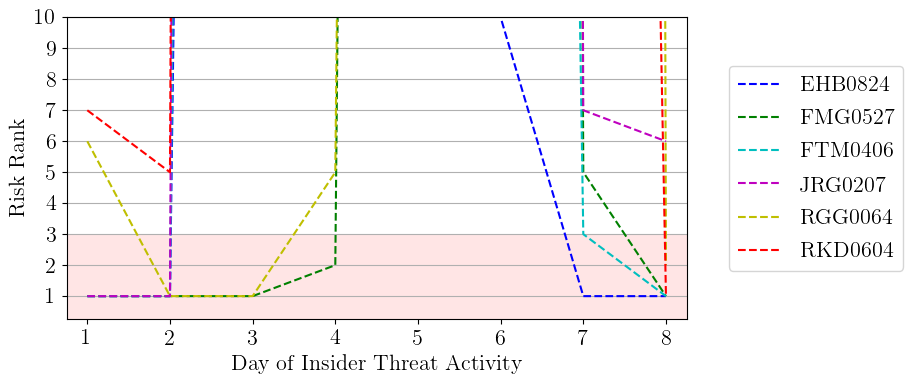

In [ ]:
DAYS = 1
AGGREGATIONS = ["max_of_25q_of_logon_anomaly_scores", "sum_of_sum_of_device_anomaly_scores", "any_of_job_portals_visited", "any_of_first_time_usb_usage_in_past_30_days", "max_of_wikileaks_uploads"]

df = pd.read_parquet(os.path.join(BASE_PATH, "risk_scores", "aggregations", f"{DAYS}_days.parquet"))
df = df[AGGREGATIONS]
df["risk_score"] = df.mean(axis=1)
df["rank"] = df.groupby("date").risk_score.rank("max", ascending=False)

results = pd.DataFrame()

for user, row in TIME_WINDOWS[TIME_WINDOWS["scenario"] != 3].iterrows():
    tmp = df.xs(user, level=1, drop_level=False)
    ts1 = (datetime.strptime(row.first_insider_activity, "%m/%d/%Y:%H:%M:%S") - timedelta(0)).strftime("%Y-%m-%d")
    ts2 = (datetime.strptime(row.last_insider_activity, "%m/%d/%Y:%H:%M:%S") + timedelta(0)).strftime("%Y-%m-%d")
    matching_date = tmp.xs(slice(ts1, ts2), level=0, drop_level=False).reset_index()
    results = pd.concat([results, matching_date["rank"].rename(user)], axis=1)

pd.set_option("precision", 2)

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(np.arange(1, len(results)+1), results["EHB0824"], linestyle="dashed", label="EHB0824")
ax.plot(np.arange(1, len(results)+1), results["FMG0527"], linestyle="dashed", label="FMG0527")
ax.plot(np.arange(1, len(results)+1), results["FTM0406"], linestyle="dashed", label="FTM0406")
ax.plot(np.arange(1, len(results)+1), results["JRG0207"], linestyle="dashed", label="JRG0207")
ax.plot(np.arange(1, len(results)+1), results["RGG0064"], linestyle="dashed", label="RGG0064")
ax.plot(np.arange(1, len(results)+1), results["RKD0604"], linestyle="dashed", label="RKD0604")
ax.axhspan(0, 3, facecolor="red", alpha=0.1)
ax.set_yticks(np.arange(1, 11))
ax.set_xlabel("Day of Insider Threat Activity")
ax.set_ylabel("Risk Rank")
ax.set_ylim(0.25, 10)
ax.set_xlim(0.75, 8.25)
ax.yaxis.grid(True)
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.savefig(f"{DAYS}-days.pdf", format="pdf", bbox_inches="tight")
plt.savefig(f"{DAYS}-days.png", bbox_inches="tight")
plt.show()

In [ ]:
tmp = pd.read_parquet(os.path.join(BASE_PATH, "risk_scores", "aggregations", "5_days.parquet"))
tmp = tmp[["max_of_75q_of_logon_anomaly_scores", "sum_of_sum_of_device_anomaly_scores", "max_of_wikileaks_uploads"]]
tmp["risk_score"] = tmp.mean(axis=1)
tmp["rank"] = tmp.groupby("date").risk_score.rank("max", ascending=False).astype(int)
tmp = tmp.xs("AJR0932", level=1, drop_level=False)
tmp.round(2)

,,max_of_75q_of_logon_anomaly_scores,sum_of_sum_of_device_anomaly_scores,max_of_wikileaks_uploads,risk_score,rank
date,user,,,,,
2010-06-01,AJR0932,0.32,0.0,NaN,0.16,975
2010-06-02,AJR0932,0.32,0.0,NaN,0.16,975
2010-06-03,AJR0932,0.32,0.0,NaN,0.16,975
2010-06-04,AJR0932,0.32,0.0,NaN,0.16,975
2010-06-05,AJR0932,0.32,0.0,NaN,0.16,975
...,...,...,...,...,...,...
2011-05-13,AJR0932,0.00,0.0,NaN,0.00,930
2011-05-14,AJR0932,0.00,0.0,NaN,0.00,930
2011-05-15,AJR0932,0.00,0.0,NaN,0.00,930


In [ ]:
def background_gradient(s, cmap="Greens", vmin=50, vmax=100, low=0, high=0.2):
    rng = vmax - vmin
    norm = colors.Normalize(vmin, vmax + (rng * high))
    if type(s) is str:
        s = float(s.split("$\pm$")[0])
    normed = norm(s)
    cmap_value = plt.cm.get_cmap(cmap)(normed)
    hex_value = colors.to_hex(cmap_value)
    return f"background-color: {hex_value}; color: black"

df = pd.DataFrame()
for item in glob.glob(os.path.join(BASE_PATH, "risk_scores", "results", "*csv")):
    df = pd.concat([df, pd.read_csv(item)])
for col in df.select_dtypes(include=["float64"]).columns.values:
    if col != "mean":
        df[col] = df[col].astype("int64")

latex_df = df.groupby("days").agg(
    all_top1=("all_top1", "max"),
    all_top3=("all_top3", "max"),
    all_top5=("all_top5", "max"),
    all_top10=("all_top10", "max"),
    all_top20=("all_top20", "max"),
    all_top30=("all_top30", "max"),
    all_top50=("all_top50", "max"),
    mean_risk_score=("mean_risk_score", "mean"),
)

style = latex_df.style
style = style.applymap(background_gradient, low=0.2, vmin=30, vmax=60)
style = style.format(precision=2)
style
print(
    style.to_latex(
        convert_css=True
    )
)

\begin{tabular}{lrrrrrrrr}
{} & {all_top1} & {all_top3} & {all_top5} & {all_top10} & {all_top20} & {all_top30} & {all_top50} & {mean_risk_score} \\
{days} & {} & {} & {} & {} & {} & {} & {} & {} \\
1 & {\cellcolor[HTML]{7FC97F}} \color{black} 47 & {\cellcolor[HTML]{0B7734}} \color{black} 60 & {\cellcolor[HTML]{0B7734}} \color{black} 60 & {\cellcolor[HTML]{0B7734}} \color{black} 60 & {\cellcolor[HTML]{0B7734}} \color{black} 60 & {\cellcolor[HTML]{0B7734}} \color{black} 60 & {\cellcolor[HTML]{0B7734}} \color{black} 60 & {\cellcolor[HTML]{00441B}} \color{black} 154.03 \\
3 & {\cellcolor[HTML]{BEE5B8}} \color{black} 40 & {\cellcolor[HTML]{2A924A}} \color{black} 56 & {\cellcolor[HTML]{137D39}} \color{black} 59 & {\cellcolor[HTML]{0B7734}} \color{black} 60 & {\cellcolor[HTML]{0B7734}} \color{black} 60 & {\cellcolor[HTML]{0B7734}} \color{black} 60 & {\cellcolor[HTML]{0B7734}} \color{black} 60 & {\cellcolor[HTML]{00441B}} \color{black} 143.28 \\
5 & {\cellcolor[HTML]{D5EFCF}} \color{black} 37 